# Машинное обучение, ФКН ВШЭ

# Семинар 11. Графы вычислений (часть 2)

## Tensorflow

Tensorflow -- это не только фреймворк для нейронных сетей, но и библиотека для разнообразных вычислений по вычислительным графам. В прошлом месяца на tensorflow реализовали даже [градиентный бустинг](https://arxiv.org/abs/1710.11555)!

In [19]:
%pylab inline
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


Рассмотрим простой пример использования tensorflow – умножим матрицу на вектор

Строим вычислительный граф:

In [20]:
x = tf.placeholder(dtype=tf.float32, shape=[3,1])
W = tf.placeholder(dtype=tf.float32, shape=[3,3])
multiplication = tf.matmul(W,x)
init = tf.initialize_all_variables()

Вычисляем наш граф в сессии

In [21]:
with tf.Session() as sess:
    sess.run(init)
    input_x = np.ones(3).reshape([3,1])
    input_W = np.arange(9).reshape([3,3])
    print(input_x)
    print(input_W)
    print(sess.run(multiplication, {
            x:input_x,
            W:input_W
        }))

[[ 1.]
 [ 1.]
 [ 1.]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[  3.]
 [ 12.]
 [ 21.]]


Пусть теперь мы хотим задать матрицу $W$ один раз и больше её не трогать

Построим вычислительный граф

In [22]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape=[3,1])
W = tf.get_variable('W', [3,3], initializer=tf.constant_initializer(0.0), dtype=tf.float32)
assign_op = W.assign(input_W)
multiplication = tf.matmul(W,x)
init = tf.initialize_all_variables()

Заметьте, что добавилась операция присваивания, но это только операция в графе, т.е. если мы не выполним её в сессии, то матрица $W$ останется нулевой.

Проверим это:

In [23]:
with tf.Session() as sess:
    sess.run(init)
    input_x = np.ones(3).reshape([3,1])
    print(input_x)
    print(input_W)
    print(sess.run(multiplication, {
            x:input_x
        }))

[[ 1.]
 [ 1.]
 [ 1.]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ 0.]
 [ 0.]
 [ 0.]]


Теперь выполним эту операцию и убедимся, что матрица $W$ приняла нужное нам значение.

In [24]:
with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_op)
    input_x = np.ones(3).reshape([3,1])
    print(input_x)
    print(input_W)
    print(sess.run(multiplication, {
            x:input_x,
            W:input_W
        }))

[[ 1.]
 [ 1.]
 [ 1.]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[  3.]
 [ 12.]
 [ 21.]]


### Вычисление градиента

Основная идея использования вычислительных графов это автоматическое вычисление градиентов.

Посмотрим как это работает - вычислим производную потенциала Леннард-Джонса

In [25]:
tf.reset_default_graph()
r = tf.placeholder(dtype=tf.float32, shape=1)
depth = 1.0
sigma = 1.0
U = 4*depth*((sigma/r)**12 - (sigma/r)**6)
grad_U = tf.gradients(U, r)
init = tf.initialize_all_variables()

In [26]:
with tf.Session() as sess:
    sess.run(init)
    r_axis = np.arange(0.98, 2.01, 0.01)
    U_axis = []
    grad_axis = []
    for r_point in r_axis:
        U_axis.append(sess.run(U, {r:[r_point]}))
        grad_axis.append(sess.run(grad_U, {r:[r_point]})[0])

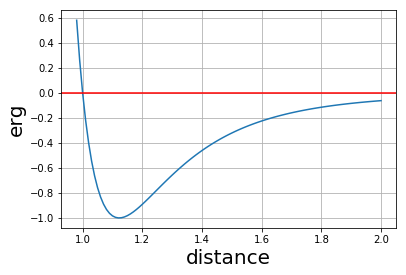

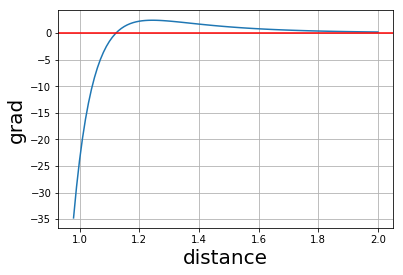

In [27]:
plt.plot(r_axis, U_axis)
plt.axhline(0.0, c='r')
plt.xlabel('distance', fontsize=20)
plt.ylabel('erg', fontsize=20)
plt.grid()
plt.show()

plt.plot(r_axis, grad_axis)
plt.axhline(0.0, c='r')
plt.xlabel('distance', fontsize=20)
plt.ylabel('grad', fontsize=20)
plt.grid()

## MNIST

<img src='images/mnist.png'>

Идея простая – на классическом довольно простом датасете с цифрами обучить сеть для классификации цифр. 

Скачаем данные:

In [28]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("tmp/data/", one_hot=False)

Extracting tmp/data/train-images-idx3-ubyte.gz
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz


Зададим некоторые параметры:

In [29]:
learning_rate = 0.001
num_steps = 2000
batch_size = 128

num_input = 784
num_classes = 10
dropout = 0.75

Реализуем архитектуру сети и её обучение:

In [30]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):    
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        fc1 = tf.contrib.layers.flatten(conv2)
        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        out = tf.layers.dense(fc1, n_classes)
    return out

In [31]:
def model_fn(features, labels, mode):
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

Инициализируем сеть и сделаем одну эпоху обучения (1 проход по обучающей выборке):

In [32]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/qd/btw7mcns7dl1t_lwnbwjclqrxngbhy/T/tmp9uuu73fa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11de15358>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [33]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=1, shuffle=True
)
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/qd/btw7mcns7dl1t_lwnbwjclqrxngbhy/T/tmp9uuu73fa/model.ckpt.
INFO:tensorflow:loss = 2.31788, step = 1
INFO:tensorflow:global_step/sec: 5.83406
INFO:tensorflow:loss = 0.1349, step = 101 (17.142 sec)
INFO:tensorflow:global_step/sec: 6.50932
INFO:tensorflow:loss = 0.102773, step = 201 (15.363 sec)
INFO:tensorflow:global_step/sec: 6.15757
INFO:tensorflow:loss = 0.0668993, step = 301 (16.241 sec)
INFO:tensorflow:global_step/sec: 4.78691
INFO:tensorflow:loss = 0.0821949, step = 401 (20.890 sec)
INFO:tensorflow:Saving checkpoints for 430 into /var/folders/qd/btw7mcns7dl1t_lwnbwjclqrxngbhy/T/tmp9uuu73fa/model.ckpt.
INFO:tensorflow:Loss for final step: 0.111167.


Сделаем предсказания на тестовой выборке:

In [34]:
y_pred = []
for y in model.predict(tf.estimator.inputs.numpy_input_fn(x={'images': mnist.test.images}, 
                                                          batch_size=batch_size, shuffle=False)):
    y_pred.append(y)

INFO:tensorflow:Restoring parameters from /var/folders/qd/btw7mcns7dl1t_lwnbwjclqrxngbhy/T/tmp9uuu73fa/model.ckpt-430


Оценим точность:

In [35]:
np.mean(np.array(y_pred) == mnist.test.labels)

0.98440000000000005